In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as vb_sparse
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import autograd

import copy
from scipy import optimize

import os
import json

import time

import pickle

analysis_name = 'simulated_data_small'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
pkl_file = open(pickle_output_filename, 'rb')
vb_data = pickle.load(pkl_file)

json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']

K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])



In [3]:
class LogisticGLMMLogPosterior(object):
    def __init__(
        self, glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec):

        self.glmm_par_draw = copy.deepcopy(glmm_par_draw)
        self.prior_par = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        self.K = x_mat.shape[1]

        assert np.min(y_g_vec) == 0
        assert np.max(y_g_vec) == self.glmm_par_draw['u'].size() - 1

    def get_log_prior(self):
        beta = self.glmm_par_draw['beta'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)
        
        cov_beta = np.zeros((self.K, self.K))
        beta_prior_info = self.prior_par['beta_prior_info'].get()
        beta_prior_mean = self.prior_par['beta_prior_mean'].get()
        log_p_beta = ef.mvn_prior(
            beta_prior_mean, beta_prior_info, beta, cov_beta)

        log_p_mu = ef.uvn_prior(
            self.prior_par['mu_prior_mean'].get(),
            self.prior_par['mu_prior_info'].get(), mu, 0.0)

        tau_prior_shape = self.prior_par['tau_prior_alpha'].get()
        tau_prior_rate = self.prior_par['tau_prior_beta'].get()
        log_p_tau = ef.gamma_prior(
            tau_prior_shape, tau_prior_rate, tau, log_tau)

        return log_p_beta + log_p_mu + log_p_tau

    def get_log_lik(self):
        beta = self.glmm_par_draw['beta'].get()
        u = self.glmm_par_draw['u'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)

        log_lik = 0.

        # Log likelihood from data.
        z = u[self.y_g_vec] + np.matmul(self.x_mat, beta)
        log_lik += np.sum(self.y_vec * z - np.log1p(np.exp(z)))

        # Log likelihood from random effect terms.
        log_lik += -0.5 * tau * np.sum((mu - u) ** 2) + 0.5 * log_tau * len(u)

        return log_lik

    def get_log_posterior(self):
        return np.squeeze(
            self.get_log_lik() + \
            self.get_log_prior())




In [4]:
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_data['num_gh_points'])

glmm_par_draw = vb.ModelParamsDict('GLMM Parameter Draw')
glmm_par_draw.push_param(vb.ScalarParam('mu', val=0.0))
glmm_par_draw.push_param(vb.ScalarParam('tau', val=1.0))
glmm_par_draw.push_param(vb.VectorParam('beta', K, val=np.full(K, 0.)))
glmm_par_draw.push_param(vb.VectorParam('u', NG))

log_model = LogisticGLMMLogPosterior(glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec)
log_model.get_log_posterior()

-696.14718055994535

In [26]:
class LogisticGLMMBootstrap(object):
    def __init__(self, model):
        self.model = model
        self.weights = np.full(model.x_mat.shape[0], 1.0)
        self.num_gh_points = 5
        self.model.set_gh_points(self.num_gh_points)
        
        self.get_weight_jacobian = autograd.jacobian(
            self.wrap_data_log_lik_terms)
        
    def wrap_data_log_lik_terms(self, free_par):
        self.model.glmm_par.set_free(free_par)
        return self.model.get_data_log_lik_terms()

    def optimize_with_weights(self, weights, init_par, gtol=1e-6, print_every=1):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.tr_optimize(
            init_par, num_gh_points=self.num_gh_points, gtol=gtol, print_every=print_every)   
    
    def get_model_weight_grad(self, free_par_vec, weights):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.objective.fun_free_grad(free_par_vec)

    
glmm_bootstrap_object = LogisticGLMMBootstrap(model)

glmm_par_free = vb_data['glmm_par_free']
elbo_hess = vb_sparse.unpack_csr_matrix(vb_data['elbo_hess_packed'])
print(elbo_hess.shape)

moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector_from_free)


(214, 214)


In [27]:
base_weights = np.full(NObs, 1.0)
print(np.sum(base_weights))
base_opt = glmm_bootstrap_object.optimize_with_weights(
    weights=base_weights, init_par=glmm_par_free, gtol=1e-8)
base_free_par = base_opt.x

1000.0
Iter  0  value:  69.4079315229
Iter  1  value:  69.4079246844
Iter  2  value:  69.4079246793
Iter  3  value:  69.4079246793
Optimization terminated successfully.
         Current function value: 69.407925
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 0


In [28]:
kl_hess = model.objective.fun_free_hessian(base_free_par)
moment_jac = get_moment_jacobian(base_free_par)
weight_jacobian = glmm_bootstrap_object.get_weight_jacobian(base_free_par)
param_boot_mat = -1 * np.linalg.solve(elbo_hess.todense(), np.transpose(weight_jacobian))
moment_boot_mat = np.matmul(moment_jac, param_boot_mat)
print(moment_boot_mat.shape)

(108, 1000)


In [43]:
# Evaluated at a linear combination of the bootstrap draw and base weights.
# Note that at the full bootstrap draw, the response is quite nonlinear.

use_jackknife = False
if use_jackknife:
    boot_draw = copy.deepcopy(base_weights)
    boot_draw[0] = 0.
else:
    boot_draw = np.random.multinomial(NObs, [1. / NObs] * NObs, size=1) - 1.0
    boot_draw = 1.0 * boot_draw + base_weights

print('Total weight (there are {} observations): {}'.format(NObs, np.sum(boot_draw)))

lr_param_diff = np.matmul(param_boot_mat, np.squeeze(boot_draw) - 1.0)
model_weight_grad = glmm_bootstrap_object.get_model_weight_grad(
    base_free_par + lr_param_diff, boot_draw)
boot_newton_step = -1 * np.linalg.solve(elbo_hess.todense(), model_weight_grad)
print(np.max(np.abs(boot_newton_step)))

Total weight (there are 1000 observations): 1000.0
3.50033270153e-06


In [44]:
glmm_par_opt_boot = glmm_bootstrap_object.optimize_with_weights(
    init_par=base_free_par + lr_param_diff, weights=boot_draw, gtol=1e-8)
boot_free_par = glmm_par_opt_boot.x

Iter  0  value:  69.4080868067
Iter  1  value:  69.4080868063
Iter  2  value:  69.4080868063
Optimization terminated successfully.
         Current function value: 69.408087
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0


True norm difference: 4.3778010554312856e-05


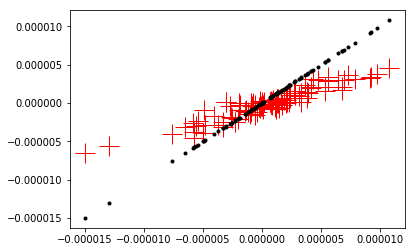

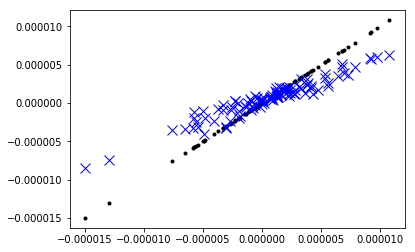

In [45]:
# The actual change in the moment vectors.
moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)
moment_vec_boot = moment_wrapper.get_moment_vector_from_free(boot_free_par)

# Use the linear approximation for the parameters, not the moments.
moment_vec_boot_step = moment_wrapper.get_moment_vector_from_free(
    base_free_par + lr_param_diff)
boot_step_moment_diff = moment_vec_boot - moment_vec_boot_step

# The difference based on a linear approximation to the moments.
lr_moment_diff = np.matmul(moment_boot_mat, np.squeeze(boot_draw) - 1.0)

true_moment_diff = moment_vec_boot - moment_vec
print('True norm difference: {}'.format(np.linalg.norm(true_moment_diff)))

plt.figure()
plt.plot(true_moment_diff, lr_moment_diff, 'r+', markersize=20)
plt.plot(true_moment_diff, true_moment_diff, 'k.')

plt.figure()
plt.plot(true_moment_diff, true_moment_diff, 'k.')
plt.plot(true_moment_diff, boot_step_moment_diff, 'bx', markersize=10)


In [ ]:
moment_indices = copy.deepcopy(moment_wrapper.moment_par)
moment_indices.set_vector(np.arange(0, moment_indices.vector_size()))
print(moment_indices)
u_ind = moment_indices['e_u'].get()
beta_ind = moment_indices['e_beta'].get()
non_u_ind = list(set(moment_indices.get_vector()) - set(u_ind))
print(non_u_ind)

#true_moment_diff[u_ind]

plt.figure()
plt.plot(true_moment_diff[u_ind], lr_moment_diff[u_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[u_ind], true_moment_diff[u_ind], 'k.')

plt.figure()
plt.plot(true_moment_diff[non_u_ind], lr_moment_diff[non_u_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[non_u_ind], true_moment_diff[non_u_ind], 'k.')


plt.figure()
plt.plot(true_moment_diff[beta_ind], lr_moment_diff[beta_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[beta_ind], true_moment_diff[beta_ind], 'k.')